# Airbnb data exploration

In this notebook we try to describe and explore the features of public datasets.

To look for more information about this public datasets look here: http://insideairbnb.com/get-the-data.html




In [348]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import matplotlib
from utils import download_datasets

In [349]:
#datasets
datasets_urls_boston = [
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/reviews.csv.gz'
]

datasets_urls_seattle = [
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/reviews.csv.gz'
]
datasets_urls_austin = [
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/tx/austin/2018-08-14/data/reviews.csv.gz'
]

download_datasets(datasets_urls_boston, 'boston_')
download_datasets(datasets_urls_seattle, 'seattle_')
download_datasets(datasets_urls_austin, 'austin_')

datasets_cities = ['seattle', 'boston', 'austin']

File: boston_listings.csv.gz, in cache
File: boston_calendar.csv.gz, in cache
File: boston_reviews.csv.gz, in cache
File: seattle_listings.csv.gz, in cache
File: seattle_calendar.csv.gz, in cache
File: seattle_reviews.csv.gz, in cache
File: austin_listings.csv.gz, in cache
File: austin_calendar.csv.gz, in cache
File: austin_reviews.csv.gz, in cache


In [350]:
#Reading files


listings = []
calendar = []
reviews = []

for city in datasets_cities:
    listings += [pd.read_csv(city+'_listings.csv.gz')]
    calendar += [pd.read_csv(city+'_calendar.csv.gz', parse_dates=['date'])]
    reviews  += [pd.read_csv(city+'_reviews.csv.gz')]

listings = pd.concat(listings)
calendar = pd.concat(calendar)
reviews = pd.concat(reviews)



/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [351]:
#transform 't' or 'f' into True or False values.
calendar.available = calendar.available.apply(lambda x: x == "t")
#remove $ sign and parse the value as numeric.
calendar.price = calendar.price.apply(lambda x: float(str(x).replace("$","").replace(",","")))

calendar.dtypes

,listing_id,date,available,price
0,1980283,2019-08-15,False,NaN
1,1980283,2019-08-14,False,NaN
2,1980283,2019-08-13,False,NaN
3,1980283,2019-08-12,False,NaN
4,1980283,2019-08-11,False,NaN
5,1980283,2019-08-10,False,NaN
6,1980283,2019-08-09,False,NaN
7,1980283,2019-08-08,False,NaN
8,1980283,2019-08-07,False,NaN
9,1980283,2019-08-06,False,NaN


In [328]:
null_percent_price = calendar.price.isnull().sum() / (calendar.price.shape[0])

print("Percent of null elements in the price column: ", null_percent_price)

Percent of null elements in the price column:  0.6196350900142947


In [329]:
#Computing scalers.
min_date = calendar.date.min()
max_date = calendar.date.max()

min_price = calendar.price.min()
max_price = calendar.price.max()

scaler_date = MinMaxScaler()
scaler_price = MinMaxScaler()

scaler_date.fit([[min_date.timestamp()], [max_date.timestamp()]])
scaler_price.fit([[min_price], [max_price]])


def slope_value(data):
    x = data.copy()
    x['date'] = x['date'].apply(lambda x: float(x.timestamp()))
    x = x.dropna()

    if x.shape[0] == 0:
        return np.nan

    X = x['date'].values.reshape(x['date'].shape[0], 1)
    y = x['price'].values.reshape(x['price'].shape[0], 1)

    X = scaler_date.transform(X)
    y = scaler_price.transform(y)

    lm = LinearRegression(n_jobs=-1)
    lm.fit(X, y)

    return lm.coef_[0][0]


def variation_metric(data):
    x = data.copy()
    x = x.dropna()
    x = x['price'].values
    if x.shape[0] == 0:
        return np.nan
    
    var_score = 0
    last_val = x[0]
    
    for val in x[1:]:
        if last_val != val:
            var_score += 1
        last_val = val
    
    return var_score
  
def minmax_metric(data):
    x = data.copy()
    x = x.dropna()
    if x.shape[0] == 0:
        return np.nan
    return x.price.min()/x.price.max()

def availability_metric(data):
    available_count = data[data.available == True]['available'].sum()
    return available_count/data.available.shape[0]

def std_metric(data):
    return data.price.std()
    
def mean_metric(data):
    return data.price.mean()

#min_max = calendar.groupby('listing_id').apply(lambda x: minmax_metric(x))
slope = calendar.groupby('listing_id').apply(lambda x: slope_value(x))
#variation = calendar.groupby('listing_id').apply(lambda x: variation_metric(x))
#available = calendar.groupby('listing_id').apply(lambda x: availability_metric(x))
#std = calendar.groupby('listing_id').apply(lambda x: std_metric(x))
#mean = calendar.groupby('listing_id').apply(lambda x: mean_metric(x))

In [330]:
#min_max.name = "min_max"
slope.name ="slope"
#variation.name = "variation"
#available.name = "available"
#std.name = "std"
#mean.name = "mean"

#combined_metrics = pd.concat([min_max, slope, variation, available, std, mean], axis=1)
combined_metrics = pd.DataFrame(slope)
scaler = MinMaxScaler()
combined_metrics = combined_metrics.dropna()
combined_metrics[combined_metrics.columns] = scaler.fit_transform(combined_metrics[combined_metrics.columns])
#corr_matrix = combined_metrics.corr()
#combined_metrics = combined_metrics.drop(['std', 'min_max', 'variation', 'slope', 'available'], axis=1)
#sns.heatmap(corr_matrix, annot=True);

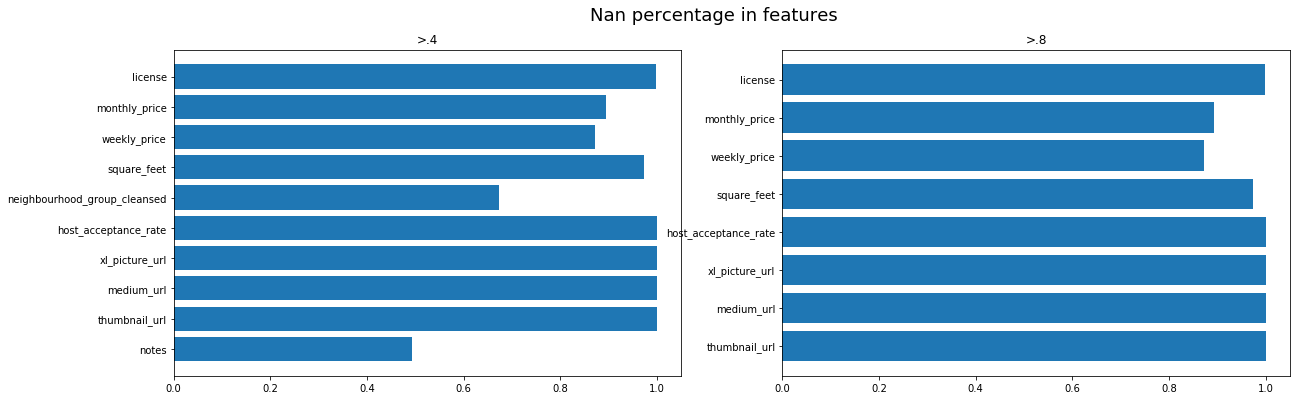

In [331]:
#Getting null % for each feature

total_size = listings.shape[0]

labels_ = [[],[]]
values_ = [[],[]]


for feature in listings:
    nulls_percentage = listings[feature].isna().sum()/total_size
    if nulls_percentage > .4:
        labels_[0] += [feature]
        values_[0] += [nulls_percentage]
    if nulls_percentage > .8:
        labels_[1] += [feature]
        values_[1] += [nulls_percentage]
    

plt.figure(1, figsize=(20, 6))
plt.suptitle('Nan percentage in features', fontsize=18)
plt.xticks(rotation='vertical')
plt.subplot(121)
plt.title('>.4')
plt.barh(labels_[0], values_[0])
plt.subplot(122)
plt.title('>.8')
plt.barh(labels_[1], values_[1])
plt.show();

In [332]:
[print(labels_[0][i], ":", values_[0][i]) for i in range(len(values_[0]))];
listings_dropna = listings.drop(labels_[1], axis=1)

notes : 0.49252984212552947
thumbnail_url : 1.0
medium_url : 1.0
xl_picture_url : 1.0
host_acceptance_rate : 1.0
neighbourhood_group_cleansed : 0.6729303041971506
square_feet : 0.9741624951867539
weekly_price : 0.8729303041971506
monthly_price : 0.8940315748941086
license : 0.9991143627262226


In [333]:
scaler = MinMaxScaler()
num_listings = listings_dropna.select_dtypes(include=np.number).dropna()
cols = list(set(num_listings.columns) - set(['id', 'scrape_id', 'host_id']))
num_listings[cols] = scaler.fit_transform(num_listings[cols])
num_listings.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20523.0,1.500862e+07,7.877103e+06,2.265000e+03,8.173136e+06,1.669155e+07,2.160886e+07,2.769813e+07
scrape_id,20523.0,2.018082e+13,1.174566e+06,2.018081e+13,2.018081e+13,2.018082e+13,2.018082e+13,2.018082e+13
host_id,20523.0,4.550954e+07,5.075500e+07,2.000000e+01,6.991842e+06,2.426302e+07,6.885439e+07,2.082981e+08
host_listings_count,20523.0,3.853746e-02,1.549930e-01,0.000000e+00,7.530120e-04,1.506024e-03,3.765060e-03,1.000000e+00
host_total_listings_count,20523.0,3.853746e-02,1.549930e-01,0.000000e+00,7.530120e-04,1.506024e-03,3.765060e-03,1.000000e+00
latitude,20523.0,5.272298e-01,4.396773e-01,0.000000e+00,1.020921e-02,6.941332e-01,9.928735e-01,1.000000e+00
longitude,20523.0,4.274888e-01,3.783737e-01,0.000000e+00,2.013789e-03,4.796052e-01,4.810378e-01,1.000000e+00
accommodates,20523.0,1.096169e-01,9.744102e-02,0.000000e+00,3.703704e-02,7.407407e-02,1.481481e-01,1.000000e+00
bathrooms,20523.0,1.020102e-01,5.200162e-02,0.000000e+00,7.407407e-02,7.407407e-02,1.111111e-01,1.000000e+00
bedrooms,20523.0,9.013417e-02,6.476545e-02,0.000000e+00,5.882353e-02,5.882353e-02,1.176471e-01,1.000000e+00


In [334]:
combined_metrics.index.name = 'id'

In [335]:
num_listings = num_listings.set_index('id')

In [336]:
result = pd.merge(combined_metrics, num_listings, on='id')

In [337]:
corr_matrix = result.corr()
corr_matrix.style.background_gradient()

,slope,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
slope,1,0.00258381,-0.00588935,0.00596915,0.00596915,-0.00088837,0.00610563,0.0321828,0.0320187,0.0230912,0.0178902,0.0327064,-0.00471875,-8.22031e-05,-0.0135959,-0.0242103,-0.0313581,-0.0235369,-0.00780172,-0.00343028,-0.00800807,-0.000801296,0.002273,0.00208728,0.00330328,-0.0013343,-0.000720046,0.00181396
scrape_id,0.00258381,1,0.00193875,0.191322,0.191322,0.844622,0.178077,-0.20056,-0.171306,-0.192273,-0.174119,-0.187648,-0.0200813,-0.00896295,-0.336509,-0.244959,-0.187028,-0.105752,0.0691296,-0.183921,-0.119216,-0.0839982,-0.0968599,-0.111605,-0.0936753,-0.168241,0.208679,0.152375
host_id,-0.00588935,0.00193875,1,-0.0877028,-0.0877028,-0.0133276,0.0280129,0.0502212,0.0280909,0.0257504,0.0548889,0.0692609,-0.0527994,-0.00690678,-0.00727637,0.0056043,0.0089332,-0.053776,-0.200708,-0.0269228,-0.0258886,-0.0245286,-0.0274125,-0.0328359,-0.00969776,-0.0163126,-0.107813,0.155464
host_listings_count,0.00596915,0.191322,-0.0877028,1,1,0.0989535,0.149281,-0.00475638,0.0156389,-0.00499793,-0.0181544,-0.0311742,-0.0106588,-0.00217764,0.129071,0.14641,0.14453,0.0452436,-0.131623,-0.194426,-0.18683,-0.0368508,-0.241144,-0.221331,-0.0389453,-0.200291,0.822848,-0.164323
host_total_listings_count,0.00596915,0.191322,-0.0877028,1,1,0.0989535,0.149281,-0.00475638,0.0156389,-0.00499793,-0.0181544,-0.0311742,-0.0106588,-0.00217764,0.129071,0.14641,0.14453,0.0452436,-0.131623,-0.194426,-0.18683,-0.0368508,-0.241144,-0.221331,-0.0389453,-0.200291,0.822848,-0.164323
latitude,-0.00088837,0.844622,-0.0133276,0.0989535,0.0989535,1,-0.376363,-0.189216,-0.173174,-0.196682,-0.177812,-0.147434,-0.0339896,-0.00939976,-0.329979,-0.220073,-0.157724,-0.116828,0.101924,-0.118342,-0.0742158,-0.0229195,-0.0607703,-0.0602711,-0.0162483,-0.100496,0.151623,0.19092
longitude,0.00610563,0.178077,0.0280129,0.149281,0.149281,-0.376363,1,0.000689382,0.022038,0.0287687,0.0255725,-0.0538219,0.0279919,0.00177684,0.0240249,-0.0195163,-0.0338396,0.0316396,-0.0678485,-0.100963,-0.0700529,-0.103519,-0.0558802,-0.0824478,-0.131557,-0.106654,0.0825041,-0.0873643
accommodates,0.0321828,-0.20056,0.0502212,-0.00475638,-0.00475638,-0.189216,0.000689382,1,0.625401,0.822913,0.858231,0.639566,-0.0428789,0.0108805,0.121539,0.0842772,0.0677609,0.125024,-0.0860504,0.0320679,-0.000692772,0.0263682,0.0147347,-0.00665675,0.00801596,-0.0237575,-0.0303518,-0.0833221
bathrooms,0.0320187,-0.171306,0.0280909,0.0156389,0.0156389,-0.173174,0.022038,0.625401,1,0.700997,0.614938,0.438586,0.00276439,0.0117074,0.109222,0.0817242,0.0633104,0.114489,-0.134219,0.0496961,0.00712896,0.00424816,0.013462,-0.00807294,-0.0139857,-0.000144785,-0.00116173,-0.177083
bedrooms,0.0230912,-0.192273,0.0257504,-0.00499793,-0.00499793,-0.196682,0.0287687,0.822913,0.700997,1,0.769647,0.555743,-0.00995882,0.00975748,0.10555,0.0690499,0.050358,0.107829,-0.142981,0.0584109,0.0171058,0.0149601,0.0387614,0.00876643,-0.0181328,0.00621189,-0.0313097,-0.183453


In [338]:
from sklearn.ensemble import RandomForestRegressor
result = result.dropna()
y = result['slope']
X = result.drop(['slope', 'scrape_id', 'host_id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

regressor = RandomForestRegressor(n_jobs=-1, n_estimators=250, warm_start=True)

regressor.fit(X=X_train, y=y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=True)

In [339]:
from sklearn.metrics import mean_absolute_error
y_pred = regressor.predict(X_test)

mae = mean_absolute_error(y_pred, y_test)

print("MAE: {0}".format(mae))

MAE: 0.00037605100992043553


In [340]:
temp = slope.dropna()

scaler.fit(temp.values.reshape(temp.shape[0],1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [341]:
y_pred_origin = scaler.inverse_transform(y_pred.reshape(y_pred.shape[0],1))
y_test_origin = scaler.inverse_transform(y_test.values.reshape(y_test.shape[0],1))

In [342]:
mean_absolute_error(y_pred_origin, y_test_origin)

0.016810006667502226

In [343]:
r2_score(y_pred=y_pred_origin, y_true=y_test_origin)

-6.35359360910102

In [344]:
std_results = pd.DataFrame(np.concatenate([y_pred_origin, y_test_origin], axis=1), columns=['pred', 'test'])

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


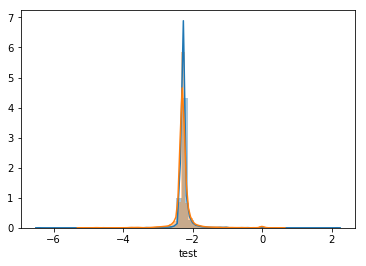

In [345]:
temp1 = np.log(std_results['pred']+.1)
sns.distplot(temp1);
temp2 = np.log(std_results['test']+.1).fillna(0)
sns.distplot(temp2);

In [355]:
calendar.columns = ['id', 'date', 'available', 'price']
calendar_listings = pd.merge(calendar, num_listings, on='id')
calendar_listings = calendar_listings.drop(['scrape_id', 'host_id', 'id'], axis=1)

Index(['date', 'available', 'price', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')